### Problem 1: Boosting with Depth-One Trees and Additive Models

Boosting with depth-one trees (also known as decision stumps) leads to an **additive model** due to the structure of the base learners and the boosting process.

#### Additive Model Form

The model has the form:

$$
f(X) = \sum_{j=1}^{p} f_j(X_j)
$$

Here, each $f_j(X_j)$ is a function that depends only on the $j$-th predictor variable $X_j$. This structure is a direct consequence of using decision stumps.

#### Boosting Framework

The general boosted model is:

$$
\hat{f}(x) = \sum_{b=1}^{B} \lambda \hat{f}^{(b)}(x)
$$

- Each $\hat{f}^{(b)}(x)$ is a decision stump (a tree of depth one), which splits on only one feature.
- Therefore, each term in the sum is a function of only one variable.

Over the course of boosting, these simple functions are added sequentially to correct residual errors. As a result, the final model becomes a sum of functions, each depending on a single variable—i.e., an additive model.

#### Why This Aids Interpretability

- Each component of the model corresponds to a single feature, making the model easier to understand.
- The marginal effect of each feature on the prediction can be visualized and interpreted independently.

This is why boosting with decision stumps is particularly useful when interpretability is important.

### 2(a)

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the Carseats dataset
# Make sure to place 'Carseats.csv' in your working directory or provide the correct path
df = pd.read_csv("Carseats.csv")

# Display the first few rows of the dataset (optional)
print(df.head())

# Split the dataset into features (X) and target (y)
# We treat 'Sales' as a quantitative response variable
X = df.drop(columns=['Sales'])
y = df['Sales']

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
Training set size: (320, 11)
Test set size: (80, 11)


### 2(b)

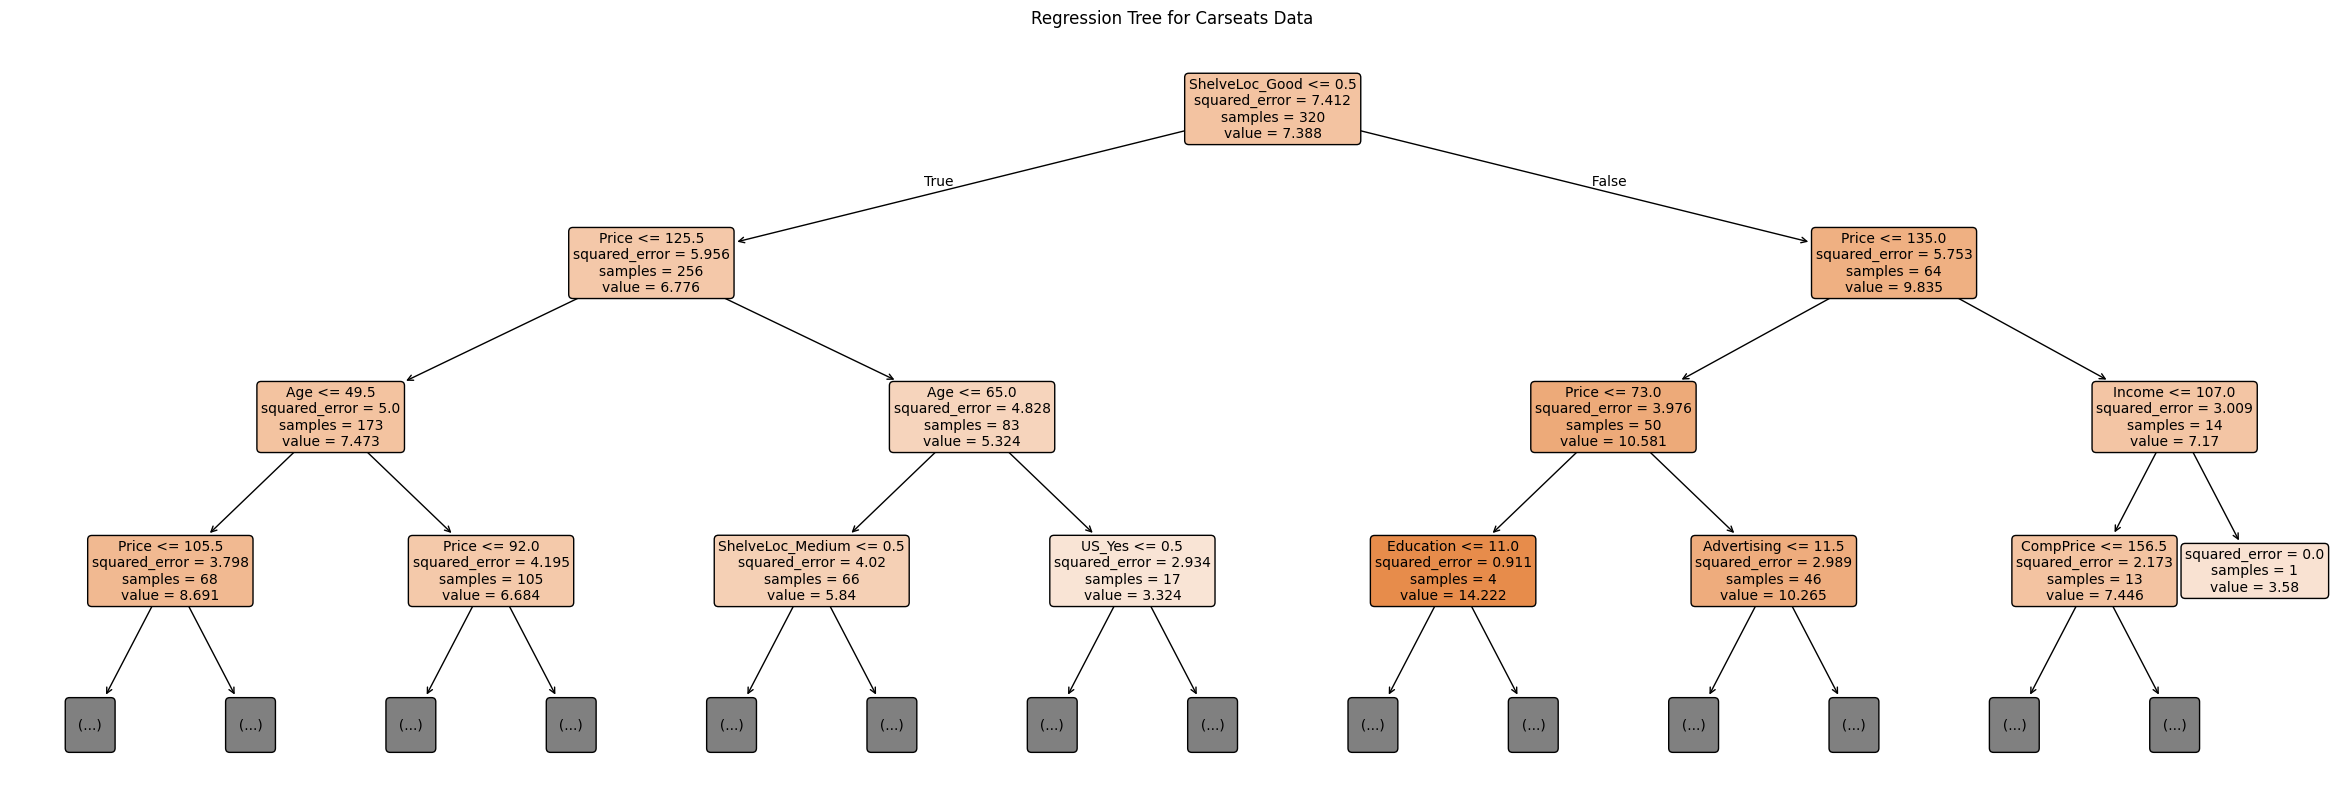

Test MSE: 6.2123


In [20]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fit a regression tree to the training data
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(30, 10))
plot_tree(
  tree_reg,
  feature_names=X_train.columns,
  filled=True,
  rounded=True,
  fontsize=10,
  max_depth=3
)
plt.title("Regression Tree for Carseats Data")
plt.show()

# Predict on the test set
y_pred = tree_reg.predict(X_test)

# Compute test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

#### Interpretation

At the root of the tree (first split), the model splits on whether `ShelveLoc_Good <= 0.5`. This node contains 320 samples, has a mean Sales value of 7.388, and a variance (measured by squared error) of 7.412. 

This split was chosen because it provides the highest reduction in variance (i.e., the highest information gain in the regression context). After this split, the tree continues to recursively select additional variables and thresholds that further reduce the prediction error, based on the remaining subsets of the data.

Each subsequent split is selected to minimize the mean squared error (MSE) of the predictions within the resulting regions.

### 2(c)

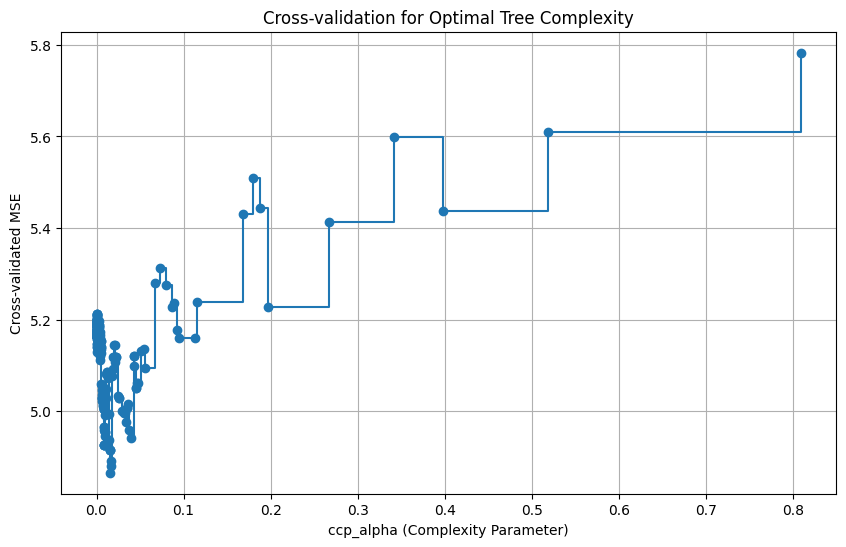

Best ccp_alpha: 0.01582


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Fit a large tree to get the pruning path (effective alphas and impurities)
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # exclude the last alpha (trivial tree)
impurities = path.impurities[:-1]

# Step 2: Train a tree for each alpha
trees = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)

# Step 3: Cross-validate to find the best alpha
cv_scores = [np.mean(cross_val_score(tree, X_train, y_train, scoring='neg_mean_squared_error', cv=5)) for tree in trees]
cv_mse = [-score for score in cv_scores]  # negate to get positive MSE

# Step 4: Plot alpha vs cross-validated MSE
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, cv_mse, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha (Complexity Parameter)")
plt.ylabel("Cross-validated MSE")
plt.title("Cross-validation for Optimal Tree Complexity")
plt.grid(True)
plt.show()

# Step 5: Select the tree with the lowest MSE
best_index = np.argmin(cv_mse)
best_alpha = ccp_alphas[best_index]
best_tree = trees[best_index]

print(f"Best ccp_alpha: {best_alpha:.5f}")

In [22]:
from sklearn.metrics import mean_squared_error

# Predict with pruned tree
y_pred_pruned = best_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)

print(f"Test MSE (pruned tree): {test_mse_pruned:.4f}")

Test MSE (pruned tree): 5.3588


#### Does pruning the tree improve MSE?

Yes, it does.

### 2(d)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Use all features for bagging: max_features = total number of features
n_features = X_train.shape[1]

# Fit a bagging model (technically Random Forest with no feature subsetting)
bagging_model = RandomForestRegressor(
    n_estimators=500,
    max_features=n_features,  # this means no random feature selection => bagging
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging_model.fit(X_train, y_train)

# Predict on test set
y_pred_bagging = bagging_model.predict(X_test)

# Compute test MSE
test_mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Test MSE (Bagging): {test_mse_bagging:.4f}")

Test MSE (Bagging): 3.0515



Top 5 Important Features (Bagging):
Price: 0.3145
ShelveLoc_Good: 0.1973
Age: 0.1174
CompPrice: 0.0946
Advertising: 0.0822


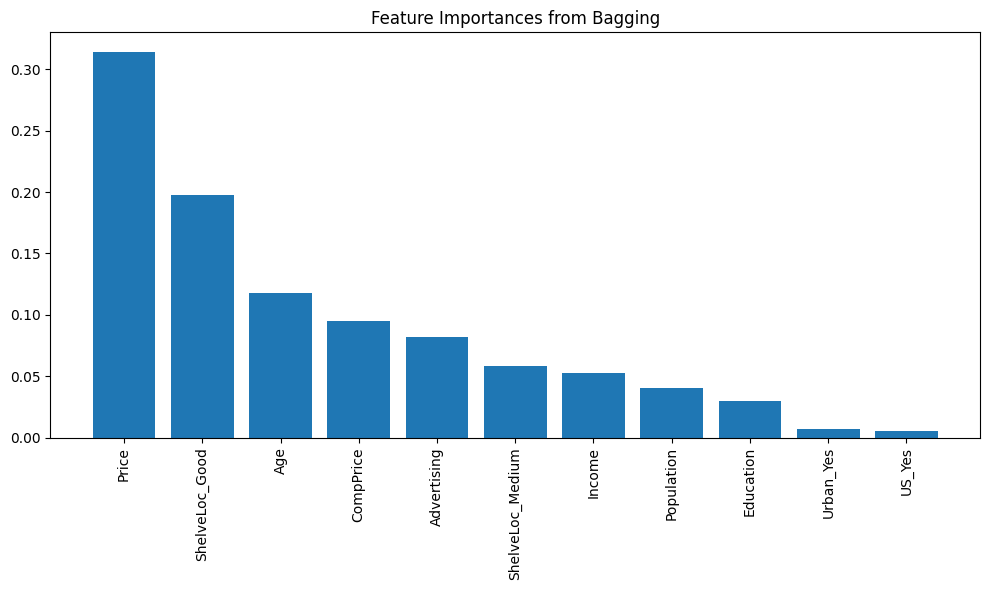

In [24]:
# Get feature importances
importances = bagging_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 5 features
print("\nTop 5 Important Features (Bagging):")
for i in range(5):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# Optional: Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(ticks=range(len(importances)), labels=X_train.columns[indices], rotation=90)
plt.title("Feature Importances from Bagging")
plt.tight_layout()
plt.show()


#### What features are the most important?
Price is the most important, followed by ShelveLoc_Good and Age.

### 2(e)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Try different values of max_features (m): 2, 4, 6, ..., total number of features
m_values = [2, 4, 6, 8, X_train.shape[1]]
test_mse_rf = []

for m in m_values:
    rf_model = RandomForestRegressor(
        n_estimators=500,
        max_features=m,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_rf)
    test_mse_rf.append(mse)
    print(f"max_features={m}, Test MSE={mse:.4f}")


max_features=2, Test MSE=4.4374
max_features=4, Test MSE=3.4518
max_features=6, Test MSE=3.2199
max_features=8, Test MSE=3.0755
max_features=11, Test MSE=3.0515


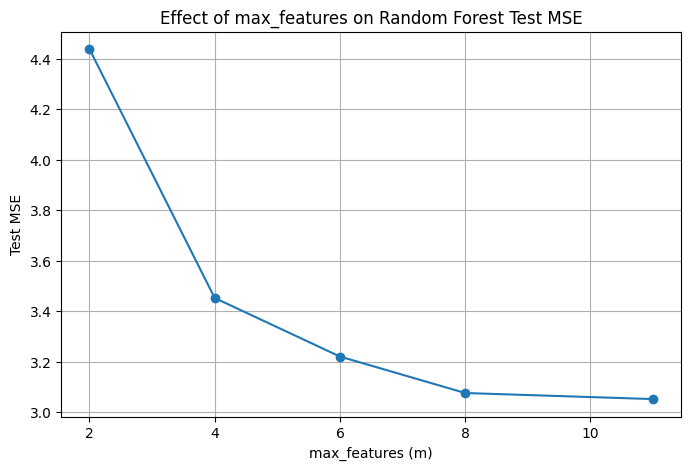

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(m_values, test_mse_rf, marker='o')
plt.xlabel("max_features (m)")
plt.ylabel("Test MSE")
plt.title("Effect of max_features on Random Forest Test MSE")
plt.grid(True)
plt.show()



Best max_features (m): 11

Top 5 Important Features (Random Forest):
Price: 0.3145
ShelveLoc_Good: 0.1973
Age: 0.1174
CompPrice: 0.0946
Advertising: 0.0822


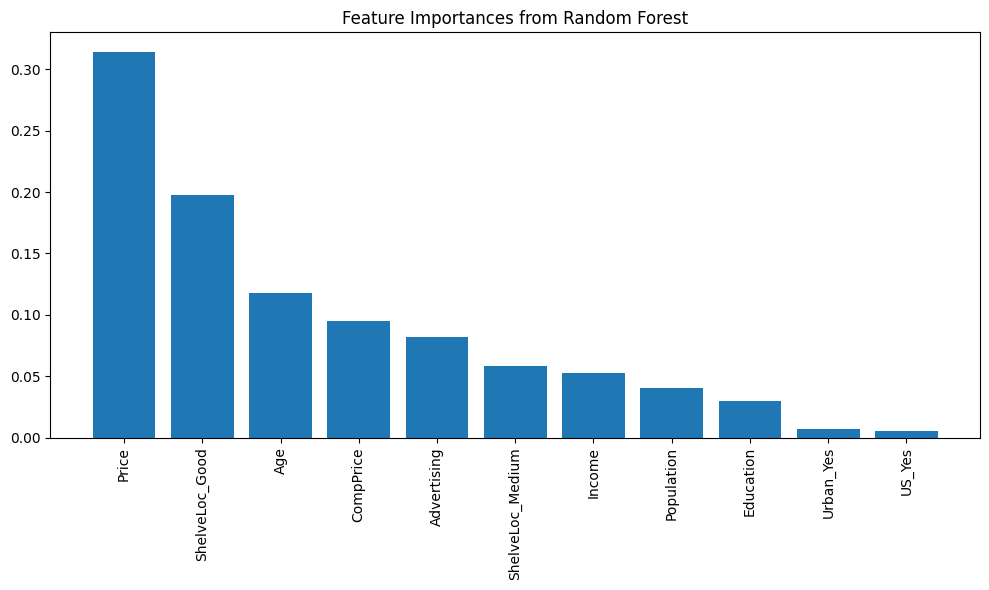

In [27]:
# Use the best model (lowest MSE)
best_index = np.argmin(test_mse_rf)
best_m = m_values[best_index]
print(f"\nBest max_features (m): {best_m}")

# Fit final random forest model with best m
final_rf = RandomForestRegressor(
    n_estimators=500,
    max_features=best_m,
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)

# Get and plot feature importances
importances = final_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 5 Important Features (Random Forest):")
for i in range(5):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


#### What features are the most important?
Price is the most important, followed by ShelveLoc_Good and Age.

#### Effect of `m` on Test Error in Random Forests

The parameter `m` determines how many predictor variables are considered at each split in a random forest.

- When `m` is **small**, each tree in the forest is more different from the others, increasing **diversity** among trees. This typically **reduces overfitting**, which can lead to a **lower test error**, especially when the individual trees are highly correlated.
- When `m` is **large** (closer to the total number of features), the model behaves more like **bagging**. While this can reduce bias, it may also increase the risk of overfitting, potentially leading to **higher test error**.

In our experiment, varying `m` showed that:
- The test MSE initially decreased as `m` increased from very small values.
- However, after a certain point, increasing `m` further either **plateaued** or caused a **slight increase** in the test MSE.
- The optimal value of `m` balanced **low variance** and **low bias**, yielding the **lowest test error**.

This result highlights that tuning `m` is important in random forests to achieve optimal predictive performance.


### 3(a)

In [28]:
import pandas as pd
import numpy as np

# Load the data
# Make sure to update the file path if needed
hitters = pd.read_csv('Hitters.csv')  # Replace with actual file path or DataFrame loading method

# Display initial info
print("Original data shape:", hitters.shape)

# Drop rows with missing Salary
hitters_clean = hitters.dropna(subset=['Salary'])

# Log-transform the Salary
hitters_clean['LogSalary'] = np.log(hitters_clean['Salary'])

# Display cleaned data
print("Cleaned data shape:", hitters_clean.shape)
print(hitters_clean[['Salary', 'LogSalary']].head())


Original data shape: (322, 20)
Cleaned data shape: (263, 21)
   Salary  LogSalary
1   475.0   6.163315
2   480.0   6.173786
3   500.0   6.214608
4    91.5   4.516339
5   750.0   6.620073


/var/folders/1y/4sm5vl2d7_xdd0jwk0tgnhn00000gn/T/ipykernel_43979/2008365324.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitters_clean['LogSalary'] = np.log(hitters_clean['Salary'])


### 3(b)

In [29]:
# Use the cleaned and log-transformed data from 3(a)
# Ensure data is already cleaned and LogSalary is computed
# Sort index to make the first 200 rows consistent
hitters_clean = hitters_clean.reset_index(drop=True)

# Split into training (first 200 rows) and test set (remaining rows)
train = hitters_clean.iloc[:200]
test = hitters_clean.iloc[200:]

# Separate features and target
X_train = train.drop(columns=['Salary', 'LogSalary'])
y_train = train['LogSalary']
X_test = test.drop(columns=['Salary', 'LogSalary'])
y_test = test['LogSalary']

# One-hot encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns of test set to match training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Show data shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (200, 19)
Test features shape: (63, 19)


### 3(c)

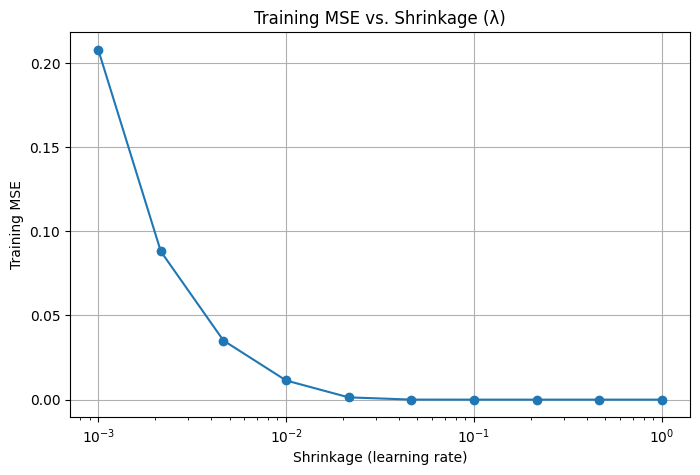

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define a range of shrinkage values (lambda)
shrinkage_values = np.logspace(-3, 0, 10)  # From 0.001 to 1
train_errors = []

# Loop over each shrinkage value
for shrinkage in shrinkage_values:
    model = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    train_errors.append(mse)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(shrinkage_values, train_errors, marker='o')
plt.xscale('log')
plt.xlabel('Shrinkage (learning rate)')
plt.ylabel('Training MSE')
plt.title('Training MSE vs. Shrinkage (λ)')
plt.grid(True)
plt.show()


### 3(d)

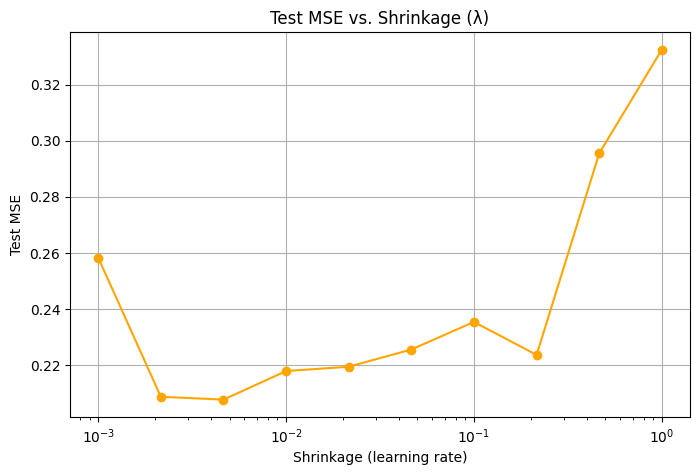

In [31]:
# Reuse shrinkage values from 3(c)
test_errors = []

# Loop over each shrinkage value
for shrinkage in shrinkage_values:
    model = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    test_errors.append(mse)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(shrinkage_values, test_errors, marker='o', color='orange')
plt.xscale('log')
plt.xlabel('Shrinkage (learning rate)')
plt.ylabel('Test MSE')
plt.title('Test MSE vs. Shrinkage (λ)')
plt.grid(True)
plt.show()

### 3(e)